# Project report : CayleyNet, another spectral graph convolution
Author : **BLANCHARD Theau**
Date : December 2022

# Necessary imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import time
import pandas as pd
import gc

import torch
from torch.nn import Parameter, Linear
import torch.nn.functional as F

import torch_geometric.profile as profile
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv import ChebConv
from torch_geometric.utils import (
    add_self_loops,
    get_laplacian,
    remove_self_loops,
    to_dense_adj,
    add_self_loops)
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data

import sys
sys.path.append("./") 
from cayleyconv import CayleyNetConv, CayleyNetConvExact

torch.manual_seed(1312)

# Networks node classification

## Cora dataset

In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print("Number of nodes: {}".format(data.num_nodes))
print("Number of edges: {}".format(data.num_edges))
print("Number of features: {}".format(data.num_features))
print("Number of classes: {}".format(dataset.num_classes))
print("Number of training nodes: {}".format(data.train_mask.sum().item()))
print("Number of validation nodes: {}".format(data.val_mask.sum().item()))
print("Number of test nodes: {}".format(data.test_mask.sum().item()))
print("Average node degree: {:.2f}".format(data.num_edges / data.num_nodes))
print("Contains isolated nodes: {}".format(data.has_isolated_nodes()))
print("Contains self-loops: {}".format(data.has_self_loops()))
print("Is undirected: {}".format(data.is_undirected()))

print("Sparsity of the input features: {:.2f}%".format(100 * data.x.count_nonzero() / data.x.shape[0] / data.x.shape[1]))

print(data)

Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Average node degree: 3.90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Sparsity of the input features: 1.27%
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
x, edge_index = data.x, data.edge_index

## On the zoom-parameter *h*

In [5]:
def cayley_transform(vals,h):
    return (h*vals - 1j)/(h*vals + 1j)

In [99]:
# Eigenvalue decomposition
edge_index, norm = get_laplacian(edge_index,normalization= None,num_nodes=x.shape[0])
laplacian = torch.sparse_coo_tensor(edge_index, norm, (x.size(0), x.size(0)), device=x.device).to_dense()
eigvals = torch.linalg.eigvals(laplacian).real
eigvals = eigvals.sort(descending=True)[0]

h_list = [0.01,0.1,1,10,100]
res = []
for h in h_list:
    cayley_eigvals = cayley_transform(eigvals,h)
    res.append(cayley_eigvals)

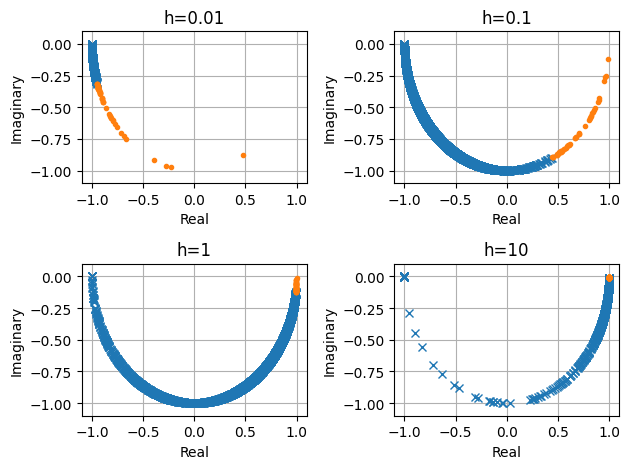

In [100]:
significant_eigvals_nb = 50
fig, axes = plt.subplots(2,2)
for h,eigvals_h,ax in zip(h_list,res,axes.flatten()):
    ax.plot(eigvals_h.real[significant_eigvals_nb:],eigvals_h.imag[significant_eigvals_nb:],'x')
    ax.plot(eigvals_h.real[:significant_eigvals_nb],eigvals_h.imag[:significant_eigvals_nb],'.')    
    ax.set_title("h="+str(h))
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,0.1)
    ax.grid()
plt.tight_layout()
plt.savefig("./influence_of_h.svg")
plt.show()

## On the influence of the order

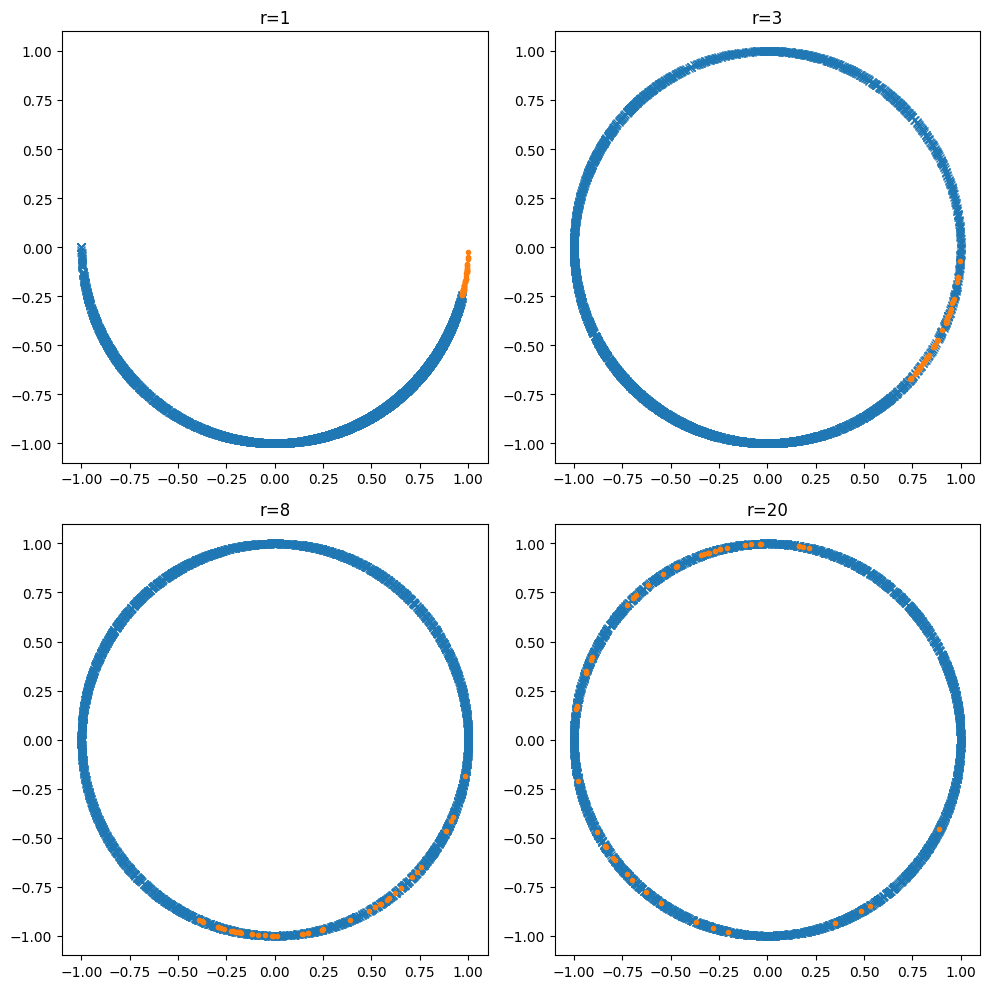

In [116]:
eigvals_r = cayley_transform(eigvals,0.5)
r_list = [1,3,8,20,35]

fig, axes = plt.subplots(2,2,figsize=(10,10))
for r,ax in zip(r_list,axes.flatten()):
    tmp = eigvals_r**r
    ax.plot(tmp.real[significant_eigvals_nb:],tmp.imag[significant_eigvals_nb:],'x')
    ax.plot(tmp.real[:significant_eigvals_nb],tmp.imag[:significant_eigvals_nb],'.')
    ax.set_title("r="+str(r))
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)

plt.tight_layout()
# plt.savefig("influence_of_r.svg")
plt.show()

## Network architectures

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

class CayleyNetJacobi(torch.nn.Module):
    def __init__(self,r=5,K=13) -> None:
        super().__init__()
        self.conv1 = CayleyNetConv(dataset.num_node_features, 16, r, K,normalization = "sym")
        self.conv2 = CayleyNetConv(16, dataset.num_classes, r, K,normalization = "sym")
    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x.float(), dim=1)

class CayleyNetExact(torch.nn.Module):
    def __init__(self,r=5) -> None:
        super().__init__()
        self.conv1 = CayleyNetConvExact(dataset.num_node_features, 16, r=r, normalization = "sym")
        self.conv2 = CayleyNetConvExact(16, dataset.num_classes, r=r,normalization = "sym")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x.float(), dim=1)


class ChebNet(torch.nn.Module):
    def __init__(self,K=11) -> None:
        super().__init__()
        self.conv1 = ChebConv(dataset.num_node_features, 16, K=K,bias=False)
        self.conv2 = ChebConv(16, dataset.num_classes, K=K,bias=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x.float(), dim=1)

In [7]:
def benchmark(model, dataset, epochs, lr = 0.01, weight_decay=5E-4, print_interval=10,show_plot=False, inspect_grad=False, device=None):
    '''
    Training and evaluation of the model
    '''

    if device is None  :
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    df_results = pd.DataFrame(columns=['loss_train','loss_val','loss_test','acc_train','acc_val','acc_test'])
    
    model.eval()
    out = model(data)
    compute_losses(out,data,0,df_results)
    print(f'Initial accuracy: {df_results["acc_test"].to_numpy()[-1]:.4f}')

    st = time.time()
    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()


        if inspect_grad:
            plot_grad_flow(model.to('cpu').named_parameters())
            model.to(device)
            
        
        model.eval()
        out = model(data)
        compute_losses(out,data,epoch,df_results)
        if epoch % print_interval == 0:
            print(f"{epoch=}",end=" ")
            print(f'Test accuracy: {df_results["acc_test"].to_numpy()[-1]:.4f}')
    
    time_elapsed = time.time()-st
    print(f"Time elapsed: {time_elapsed:.2f} s")

    model.eval()
    out=  model(data)
    compute_losses(out,data,epochs,df_results)
    acc = df_results["acc_test"].to_numpy()[-1]
    print(f'Final test accuracy: {acc:.4f}')
    

    if show_plot:
        plt.plot(df_results["acc_train"],label="train")
        plt.plot(df_results["acc_val"],label="val")
        plt.plot(df_results["acc_test"],label="test")
        plt.show()

    del data
    del model
    del optimizer
    del out
    torch.cuda.empty_cache()
    
    return df_results,time_elapsed
    

def compute_losses(out,data,epoch,df_results):
    loss_train = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_val = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    loss_test = F.nll_loss(out[data.test_mask], data.y[data.test_mask])

    pred = out.argmax(dim=1)
    correct_train = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    correct_val = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    correct_test = (pred[data.test_mask] == data.y[data.test_mask]).sum()

    acc_train = int(correct_train) / int(data.train_mask.sum())
    acc_val = int(correct_val) / int(data.val_mask.sum())
    acc_test = int(correct_test) / int(data.test_mask.sum())

    df_results.loc[epoch] = [loss_train.item(),loss_val.item(),loss_test.item(),acc_train,acc_val,acc_test]

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow

    Function found at : https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.mean())
            max_grads.append(p.grad.max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.02, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    

In [8]:
r = 6
K = 5

epochs = 100

print("Number of parameters")
print("=============================")
print("GCN : ",profile.count_parameters(GCN()))
print("CayleyNetJacobi : ",profile.count_parameters(CayleyNetJacobi(r=r,K=K)))
print("ChebNet 2r-1 : ",profile.count_parameters(ChebNet(K=r*2-1)))
print("ChebNet r : ",profile.count_parameters(ChebNet(K=r)))


Number of parameters
GCN :  23063
CayleyNetJacobi :  299522
ChebNet 2r-1 :  253440
ChebNet r :  138240


## CayleyNet

In [8]:
model = CayleyNetJacobi(r,K)
print("Number of parameters :",profile.count_parameters(model))
df_cnet_jacobi,t_cnet_jacobi = benchmark(model,dataset,epochs=epochs,lr = 5e-3,print_interval=5)
print(model.conv1.h)
print(model.conv2.h)
del model
torch.cuda.empty_cache()
gc.collect()

Number of parameters : 299522
Initial accuracy: 0.0980
epoch=0 Test accuracy: 0.2220
epoch=5 Test accuracy: 0.4980
epoch=10 Test accuracy: 0.6020
epoch=15 Test accuracy: 0.6420
epoch=20 Test accuracy: 0.6610
epoch=25 Test accuracy: 0.6730
epoch=30 Test accuracy: 0.6730
epoch=35 Test accuracy: 0.6730
epoch=40 Test accuracy: 0.7020
epoch=45 Test accuracy: 0.7070
epoch=50 Test accuracy: 0.7220
epoch=55 Test accuracy: 0.7150
epoch=60 Test accuracy: 0.7030
epoch=65 Test accuracy: 0.7230
epoch=70 Test accuracy: 0.7260
epoch=75 Test accuracy: 0.7270
epoch=80 Test accuracy: 0.7210
epoch=85 Test accuracy: 0.7340
epoch=90 Test accuracy: 0.7350
epoch=95 Test accuracy: 0.7430
Time elapsed: 249.33 s
Final test accuracy: 0.7350
Parameter containing:
tensor([1.0428], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.1559], device='cuda:0', requires_grad=True)


1714

In [9]:
model = CayleyNetExact(r)
df_cnet_exact, t_cnet_exact = benchmark(model,dataset,epochs=epochs,lr = 1e-3,print_interval=5)
del model
torch.cuda.empty_cache()
gc.collect()

Initial accuracy: 0.1700
epoch=0 Test accuracy: 0.2170
epoch=5 Test accuracy: 0.3920
epoch=10 Test accuracy: 0.4840
epoch=15 Test accuracy: 0.5100
epoch=20 Test accuracy: 0.5100
epoch=25 Test accuracy: 0.5030
epoch=30 Test accuracy: 0.5120
epoch=35 Test accuracy: 0.5190
epoch=40 Test accuracy: 0.5210
epoch=45 Test accuracy: 0.5200
epoch=50 Test accuracy: 0.5240
epoch=55 Test accuracy: 0.5340
epoch=60 Test accuracy: 0.5340
epoch=65 Test accuracy: 0.5400
epoch=70 Test accuracy: 0.5410
epoch=75 Test accuracy: 0.5430
epoch=80 Test accuracy: 0.5420
epoch=85 Test accuracy: 0.5440
epoch=90 Test accuracy: 0.5460
epoch=95 Test accuracy: 0.5460
Time elapsed: 421.57 s
Final test accuracy: 0.5440


608

## GCN

In [10]:
model = GCN()
print("Number of parameters :",profile.count_parameters(model))
df_results_GCN,t_gcn = benchmark(model,dataset,epochs=epochs,lr=5e-3)
del model
gc.collect()
torch.cuda.empty_cache()

Number of parameters : 23063
Initial accuracy: 0.2980
epoch=0 Test accuracy: 0.3620
epoch=10 Test accuracy: 0.5940
epoch=20 Test accuracy: 0.7790
epoch=30 Test accuracy: 0.8000
epoch=40 Test accuracy: 0.8110
epoch=50 Test accuracy: 0.8150
epoch=60 Test accuracy: 0.8150
epoch=70 Test accuracy: 0.8250
epoch=80 Test accuracy: 0.8140
epoch=90 Test accuracy: 0.8080
Time elapsed: 1.26 s
Final test accuracy: 0.8150


## ChebNet

In [11]:
model=ChebNet(K=r*2-1)
print("Number of parameters :",profile.count_parameters(model))
df_cheb_same_param, t_cheb_same_param = benchmark(model,dataset,epochs=epochs, lr=5e-3,print_interval=10)

del model
gc.collect()
torch.cuda.empty_cache()
print()

model = ChebNet(K=r)
print("Number of parameters :",profile.count_parameters(model))
df_cheb_same_order, t_cheb_same_order = benchmark(model,dataset,epochs=epochs, lr=5e-3,print_interval=10)
del model
torch.cuda.empty_cache()

Number of parameters : 253440
Initial accuracy: 0.1240
epoch=0 Test accuracy: 0.2640
epoch=10 Test accuracy: 0.4230
epoch=20 Test accuracy: 0.5200
epoch=30 Test accuracy: 0.5210
epoch=40 Test accuracy: 0.5160
epoch=50 Test accuracy: 0.5090
epoch=60 Test accuracy: 0.5350
epoch=70 Test accuracy: 0.5610
epoch=80 Test accuracy: 0.5710
epoch=90 Test accuracy: 0.5890
Time elapsed: 12.84 s
Final test accuracy: 0.5950

Number of parameters : 138240
Initial accuracy: 0.1120
epoch=0 Test accuracy: 0.1660
epoch=10 Test accuracy: 0.4690
epoch=20 Test accuracy: 0.5410
epoch=30 Test accuracy: 0.5800
epoch=40 Test accuracy: 0.5770
epoch=50 Test accuracy: 0.5680
epoch=60 Test accuracy: 0.5880
epoch=70 Test accuracy: 0.6050
epoch=80 Test accuracy: 0.6200
epoch=90 Test accuracy: 0.6280
Time elapsed: 7.28 s
Final test accuracy: 0.6240


## Results

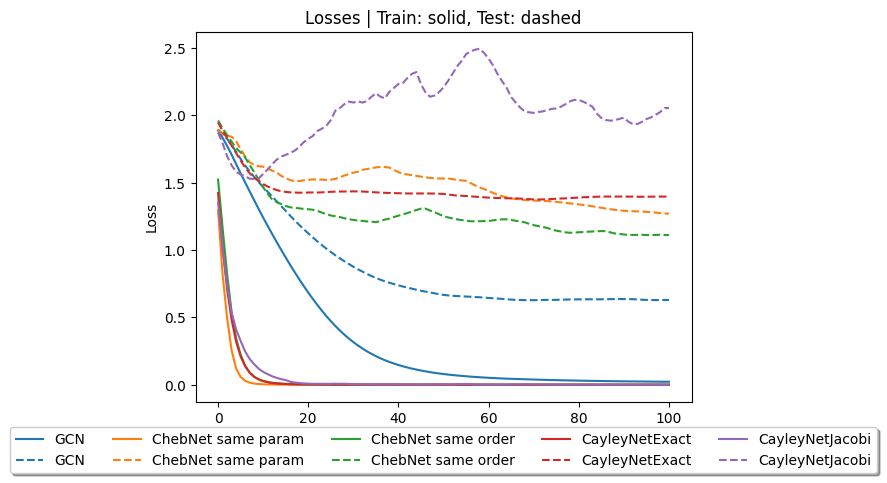

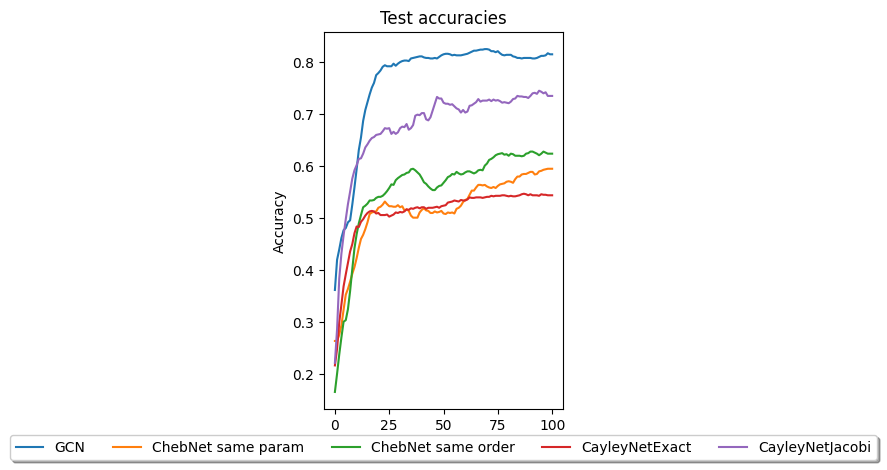

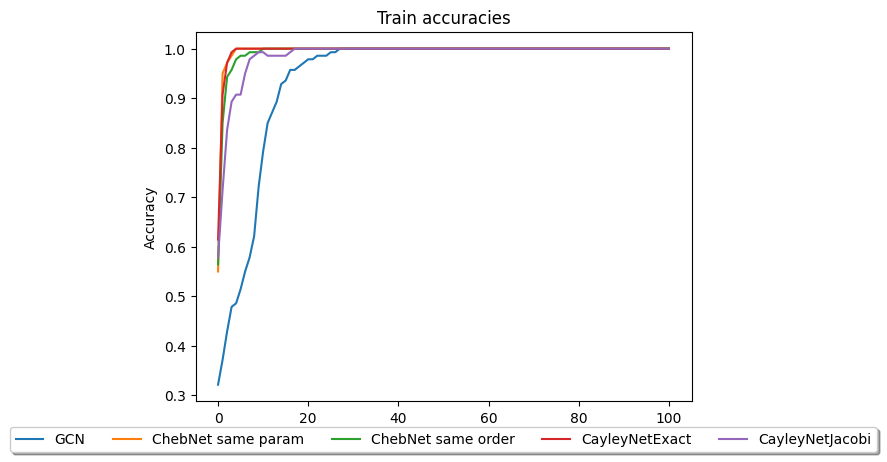

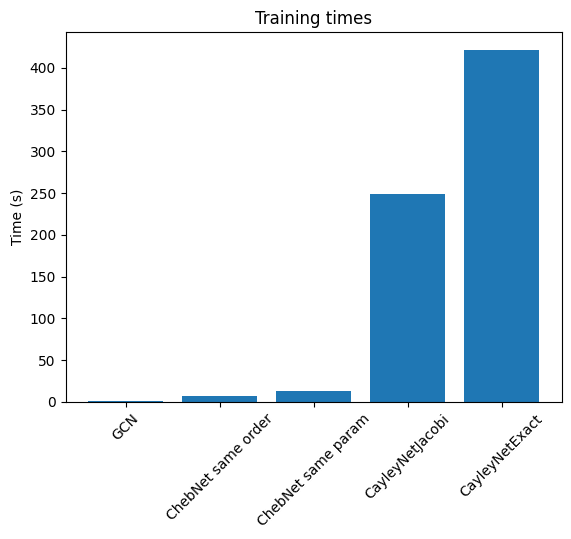

In [61]:
#Plot the losses
plt.plot(df_results_GCN["loss_train"],label="GCN",c="C0")
plt.plot(df_results_GCN["loss_test"],label="GCN",c="C0",linestyle="--")
plt.plot(df_cheb_same_param["loss_train"],label="ChebNet same param",c="C1")
plt.plot(df_cheb_same_param["loss_test"],label="ChebNet same param",c="C1",linestyle="--")
plt.plot(df_cheb_same_order["loss_train"],label="ChebNet same order",c="C2")
plt.plot(df_cheb_same_order["loss_test"],label="ChebNet same order",c="C2",linestyle="--")
plt.plot(df_cnet_exact["loss_train"],label="CayleyNetExact",c="C3")
plt.plot(df_cnet_exact["loss_test"],label="CayleyNetExact",c="C3",linestyle="--")
plt.plot(df_cnet_jacobi["loss_train"],label="CayleyNetJacobi",c="C4")
plt.plot(df_cnet_jacobi["loss_test"],label="CayleyNetJacobi",c="C4",linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Losses | Train: solid, Test: dashed")
plt.show()

#Plot the test accuracies
plt.plot(df_results_GCN["acc_test"],label="GCN")
plt.plot(df_cheb_same_param["acc_test"],label="ChebNet same param")
plt.plot(df_cheb_same_order["acc_test"],label="ChebNet same order")
plt.plot(df_cnet_exact["acc_test"],label="CayleyNetExact")
plt.plot(df_cnet_jacobi["acc_test"],label="CayleyNetJacobi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Test accuracies")
plt.tight_layout()
plt.show()

#Plot the train accuracies
plt.plot(df_results_GCN["acc_train"],label="GCN")
plt.plot(df_cheb_same_param["acc_train"],label="ChebNet same param")
plt.plot(df_cheb_same_order["acc_train"],label="ChebNet same order")
plt.plot(df_cnet_exact["acc_train"],label="CayleyNetExact")
plt.plot(df_cnet_jacobi["acc_train"],label="CayleyNetJacobi")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Train accuracies")
plt.show()

# Plot the training times sorted by increasing time
model_names = ["GCN","ChebNet same param","ChebNet same order","CayleyNetExact","CayleyNetJacobi"]
model_times = [t_gcn,t_cheb_same_param,t_cheb_same_order,t_cnet_exact,t_cnet_jacobi]
model_times, model_names = zip(*sorted(zip(model_times, model_names)))
plt.bar(model_names,model_times)
plt.ylabel("Time (s)")
plt.xticks(rotation=45)
plt.title("Training times")
plt.show()



## Accuracy depending on the original value of the parameter h

In [72]:
h_list = np.array([0.001,0.01,0.1,0.5,1,2,5,10,20])
h_list

array([1.e-03, 1.e-02, 1.e-01, 5.e-01, 1.e+00, 2.e+00, 5.e+00, 1.e+01,
       2.e+01])

In [73]:
df_h_list = []
h_values = dict()
for h in h_list:
    print("h = ",h)
    model = CayleyNetJacobi(r,K)
    model.conv1.h = Parameter(torch.tensor(h))
    model.conv2.h = Parameter(torch.tensor(h))
    df_h, t_cnet_jacobi = benchmark(model,dataset,epochs=50,lr = 5e-3,print_interval=10)
    df_h_list.append(df_h)
    h_values[h] = [model.conv1.h.detach().cpu().numpy(),model.conv2.h.detach().cpu().numpy()]

    del model
    gc.collect()
    torch.cuda.empty_cache()
    print()
    

h =  0.001
Initial accuracy: 0.1660
epoch=0 Test accuracy: 0.3400
epoch=10 Test accuracy: 0.4860
epoch=20 Test accuracy: 0.5240
epoch=30 Test accuracy: 0.4940
epoch=40 Test accuracy: 0.5140
Time elapsed: 123.47 s
Final test accuracy: 0.5050

h =  0.01
Initial accuracy: 0.0950
epoch=0 Test accuracy: 0.2670
epoch=10 Test accuracy: 0.4810
epoch=20 Test accuracy: 0.4800
epoch=30 Test accuracy: 0.5150
epoch=40 Test accuracy: 0.5040
Time elapsed: 123.70 s
Final test accuracy: 0.5020

h =  0.1
Initial accuracy: 0.1340
epoch=0 Test accuracy: 0.2660
epoch=10 Test accuracy: 0.4630
epoch=20 Test accuracy: 0.4720
epoch=30 Test accuracy: 0.4740
epoch=40 Test accuracy: 0.4900
Time elapsed: 124.65 s
Final test accuracy: 0.4890

h =  0.5
Initial accuracy: 0.1090
epoch=0 Test accuracy: 0.1190
epoch=10 Test accuracy: 0.2500
epoch=20 Test accuracy: 0.2530
epoch=30 Test accuracy: 0.2670
epoch=40 Test accuracy: 0.2410
Time elapsed: 125.75 s
Final test accuracy: 0.2420

h =  1.0
Initial accuracy: 0.1380
epo

In [77]:
h_values

{0.001: [array(-0.000174), array(-2.20465592e-05)],
 0.01: [array(-0.00044609), array(-0.00068464)],
 0.1: [array(-0.00475004), array(-0.00079225)],
 0.5: [array(0.53101588), array(0.51655068)],
 1.0: [array(1.06309117), array(1.11605397)],
 2.0: [array(1.93447655), array(1.95591175)],
 5.0: [array(5.05495782), array(5.00863101)],
 10.0: [array(9.76081067), array(9.7827088)],
 20.0: [array(19.74994828), array(19.75048738)]}

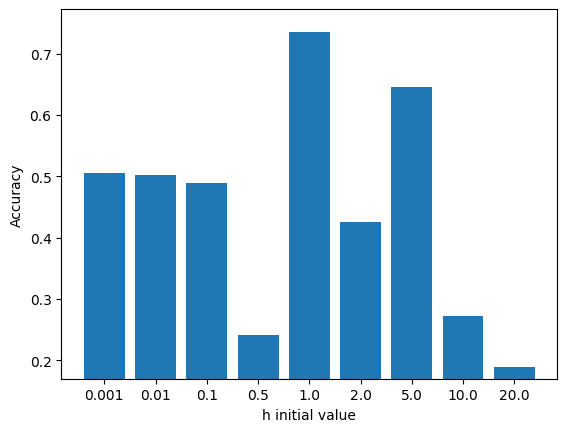

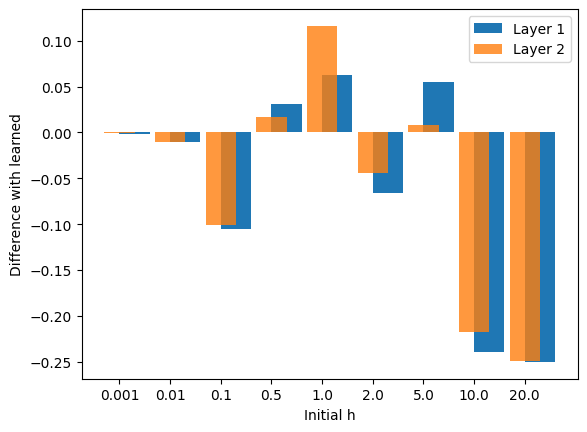

In [115]:
#Plot the final test accuracies depending on h
final_acc = [df_h_list[i]["acc_test"].iloc[-1] for i in range(len(df_h_list))]
plt.bar(range(len(h_list)),final_acc)
plt.xlabel("h initial value")
plt.ylabel("Accuracy")
plt.xticks(range(len(h_list)),h_list)
plt.ylim(np.min(final_acc)*0.9)
# plt.savefig("init_h.svg")
plt.show()

#Plot the learned h parameters as delta with original values
h1 = [h_values[h][0] for h in h_list]
h2 = [h_values[h][1] for h in h_list]
plt.bar(range(len(h_list)),h1-h_list,label="Layer 1",alpha=1,align="edge",width=0.6)
plt.bar(range(len(h_list)),h2-h_list,label="Layer 2",alpha=0.8,align="center",width=0.6)
plt.xlabel("Initial h")
plt.ylabel("Difference with learned")
plt.xticks(range(len(h_list)),h_list)
plt.legend()  
# plt.savefig("learned_h.svg")  
plt.show()



## Accuracy depending on the order r

In [13]:
import gc
df_list = []
time_elapsed_list = []
for r in range(1,10):
    print('\nModel with order ',r,' and K = ',K,'')
    model = CayleyNetJacobi(r,K)
    df_results,time_elapsed = benchmark(model,dataset,epochs=epochs,lr = 5e-3,print_interval=10,show_plot=False)
    df_list.append(df_results)
    time_elapsed_list.append(time_elapsed)
    del model
    gc.collect()
    torch.cuda.empty_cache()


Model with order  1  and K =  5 
Initial accuracy: 0.1380
epoch=0 Test accuracy: 0.2230
epoch=10 Test accuracy: 0.5630
epoch=20 Test accuracy: 0.6110
epoch=30 Test accuracy: 0.6480
epoch=40 Test accuracy: 0.6740
epoch=50 Test accuracy: 0.6810
epoch=60 Test accuracy: 0.7150
epoch=70 Test accuracy: 0.7150
epoch=80 Test accuracy: 0.7190
epoch=90 Test accuracy: 0.7290
Time elapsed: 42.95 s
Final test accuracy: 0.7310

Model with order  2  and K =  5 
Initial accuracy: 0.1640
epoch=0 Test accuracy: 0.3100
epoch=10 Test accuracy: 0.6360
epoch=20 Test accuracy: 0.7120
epoch=30 Test accuracy: 0.7360
epoch=40 Test accuracy: 0.7480
epoch=50 Test accuracy: 0.7610
epoch=60 Test accuracy: 0.7590
epoch=70 Test accuracy: 0.7670
epoch=80 Test accuracy: 0.7690
epoch=90 Test accuracy: 0.7730
Time elapsed: 83.49 s
Final test accuracy: 0.7810

Model with order  3  and K =  5 
Initial accuracy: 0.2050
epoch=0 Test accuracy: 0.2910
epoch=10 Test accuracy: 0.6570
epoch=20 Test accuracy: 0.7320
epoch=30 Test

RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 4.00 GiB total capacity; 2.69 GiB already allocated; 0 bytes free; 2.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
final_acc = []
r_list = np.arange(len(df_list))
for df_r in df_list:
    final_acc.append(np.array(df_r["acc_test"])[-1])
final_acc = np.array(final_acc)

idx = np.argsort(final_acc)
final_acc = final_acc[idx]
r_list =r_list[idx] 

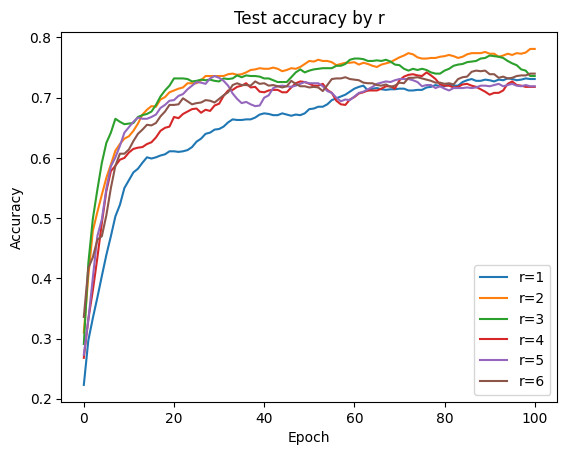

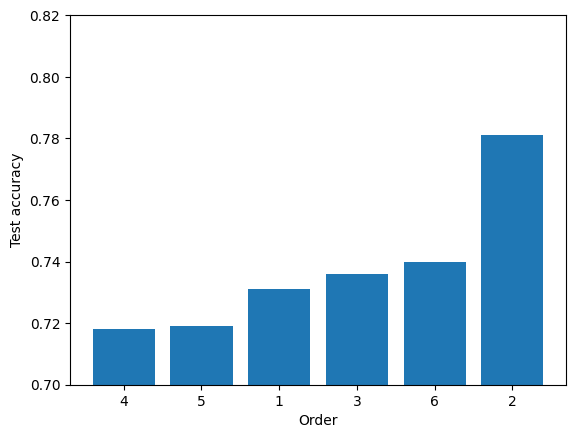

[42.954647064208984, 83.4905834197998, 125.38266611099243, 168.01809930801392, 209.14326906204224, 250.87972855567932]


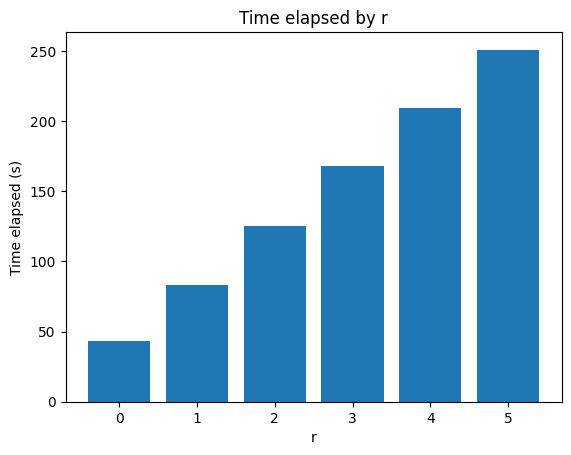

In [60]:
# Plot the results by r
for r,df_res in enumerate(df_list):
    plt.plot(df_res["acc_test"],label="r="+str(r+1))

plt.legend()
plt.title("Test accuracy by r")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.bar(range(len(idx)),final_acc)
plt.xticks(ticks = range(len(idx)),labels=idx+1)
plt.xlabel("Order")
plt.ylabel("Test accuracy")
plt.ylim(0.7)
plt.show()

# Plot the time elapsed by r
print(time_elapsed_list)
plt.bar(np.arange(len(time_elapsed_list)),time_elapsed_list)
plt.title("Time elapsed by r")
plt.xlabel("r")
plt.ylabel("Time elapsed (s)")
plt.show()